# 0.0 Imports

In [95]:
import math
import warnings
import inflection

import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import HTML
from IPython.display import Image


## 0.1 Aux Functions

In [73]:
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (30,25)
plt.rcParams.update({'font.size': 22})

## 0.2 Load Data

In [15]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False )

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0 Descriptive Statistical

## 1.1 Rename Columns

In [17]:
df1 = df_raw.copy()

In [22]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

sk = lambda x: inflection.underscore( x )

new_cols = list(map( sk, old_cols ))

df1.columns = new_cols

## 1.2 Data Dimension

In [78]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 20


## 1.3 Change Types

In [24]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check Na

In [25]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout  Na

In [34]:
#competition_distance 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) 
                                                 else x['competition_open_since_month'], axis=1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'], axis=1 )

#promo2_since_week      
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) 
                                      else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) 
                                      else x['promo2_since_year'], axis=1 )

#promo_interval
df1['promo_interval'].fillna( 0, inplace=True )

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0
                             else 1 if x['month_map'] in x['promo_interval'].split(',')
                             else 0, axis=1 )

## 1.6 Change Types

In [92]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')     
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')    
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

df1['state_holiday'] = df1['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' 
                                                   else 'easter_holiday' if x == 'b' 
                                                   else 'christmans' if x == 'c' 
                                                   else 'regular_day' )

df1['assortment'] = df1['assortment'].apply( lambda x: 'basic' if x == 'a' 
                                             else 'extra' if x == 'b' 
                                             else 'extended' )

## 1.7 Descriptive Statistical

In [42]:
num_att = df1.select_dtypes( include=['int64', 'float64'] )
cat_att = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Numerical Attributes

In [52]:
# Central Tendency ( Mean, Median )
c1 = pd.DataFrame( num_att.apply( np.mean ) ).T
c2 = pd.DataFrame( num_att.apply( np.median ) ).T

# Dispersion Means ( Min, Max, Std, Range, Skew, Kurtosis )
t1 = pd.DataFrame( num_att.apply( min ) ).T
t2 = pd.DataFrame( num_att.apply( max ) ).T
t3 = pd.DataFrame( num_att.apply( np.std ) ).T
t4 = pd.DataFrame( num_att.apply( lambda x: x.max() - x.min() ) ).T
t5 = pd.DataFrame( num_att.apply( lambda x: x.skew() ) ).T
t6 = pd.DataFrame( num_att.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [t1, t2, c1, c2, t3, t4, t5, t6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'mean', 'median', 'std', 'range', 'skew', 'kurtosis']
m

,attributes,min,max,mean,median,std,range,skew,kurtosis
0,store,1.0,1115.0,558.429727,558.0,321.908493,1114.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,3.998341,4.0,1.997390,6.0,0.001593,-1.246873
2,sales,0.0,41551.0,5773.818972,5744.0,3849.924283,41551.0,0.641460,1.778375
3,customers,0.0,7388.0,633.145946,609.0,464.411506,7388.0,1.598650,7.091773
4,open,0.0,1.0,0.830107,1.0,0.375539,1.0,-1.758045,1.090723
5,promo,0.0,1.0,0.381515,0.0,0.485758,1.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,0.178647,0.0,0.383056,1.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,5935.442677,2330.0,12547.646829,199980.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,6.786849,7.0,3.311085,11.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,2010.324840,2012.0,5.515591,115.0,-7.235657,124.071304


### 1.7.2 Categorical Attributes

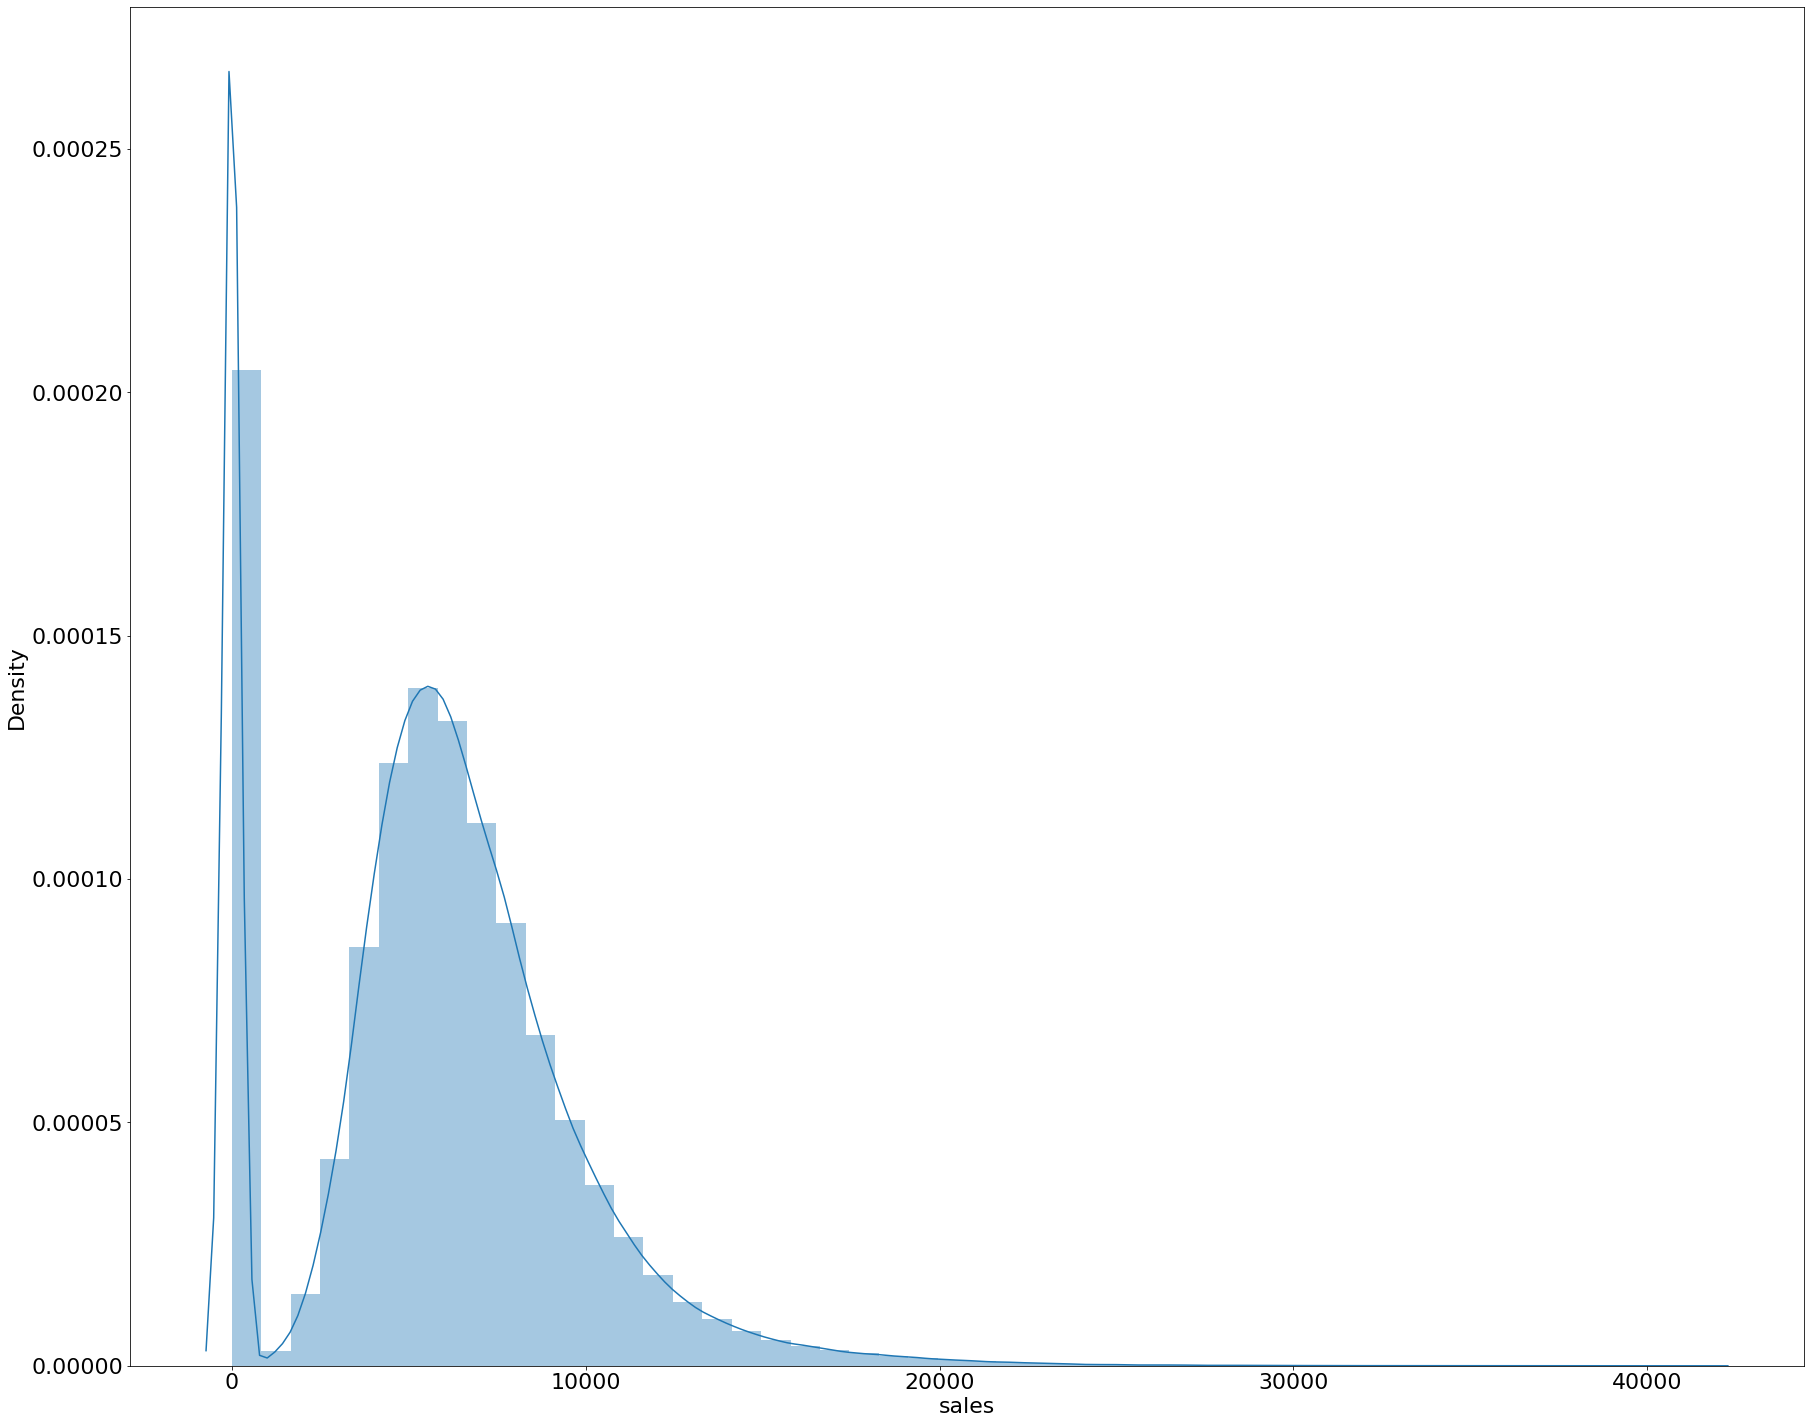

In [75]:
sns.distplot( df1['sales'] );

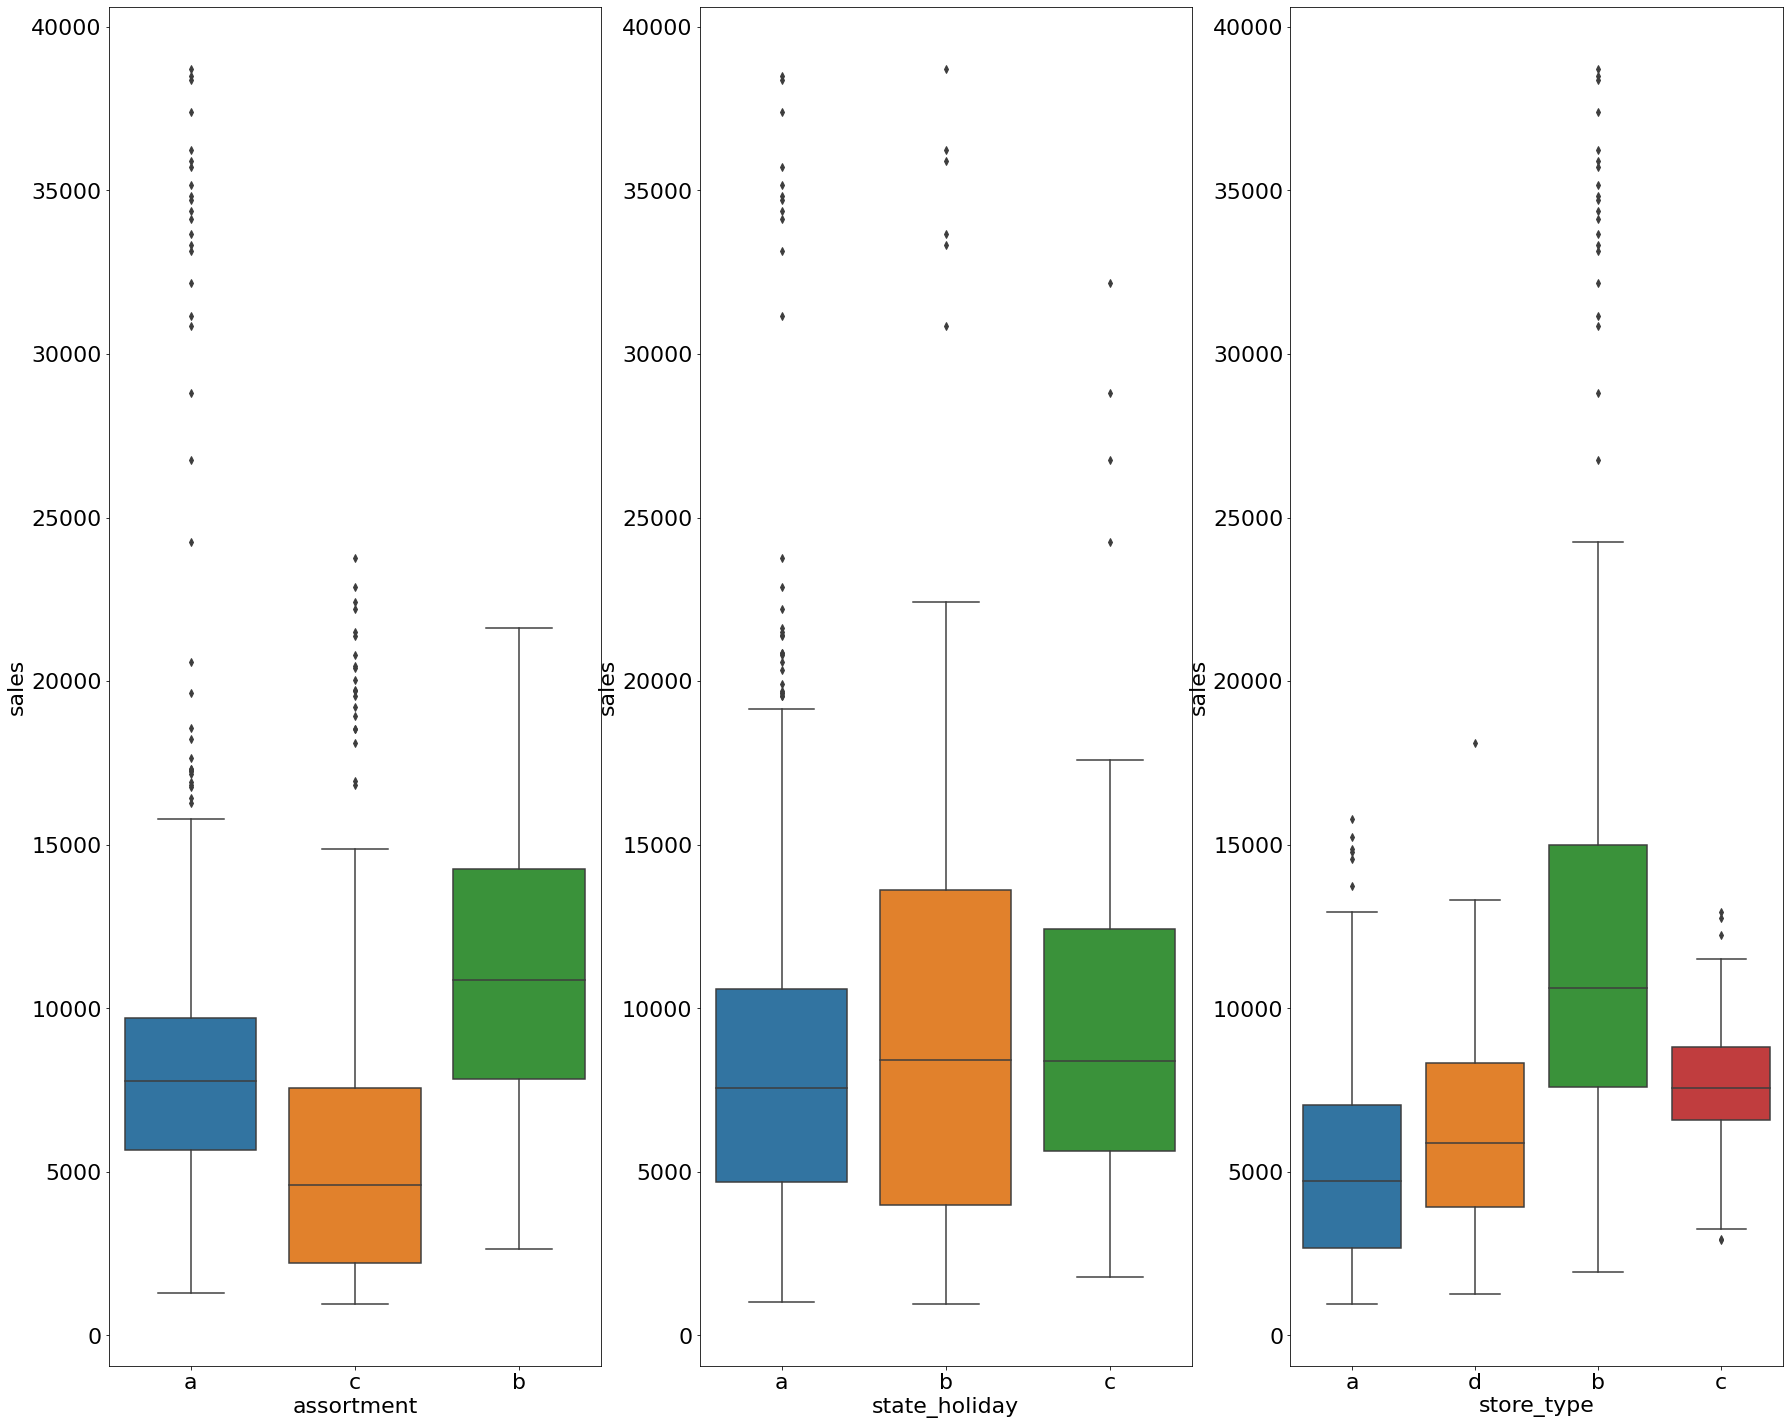

In [74]:
aux1 = df1[(df1['sales'] > 0) & (df1['open'] != 0) & (df1['state_holiday'] != '0')]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='assortment', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='store_type', y='sales', data=aux1 );

# 2.0 Feature Engineering

## 2.1 Mind Map Hypotesis 

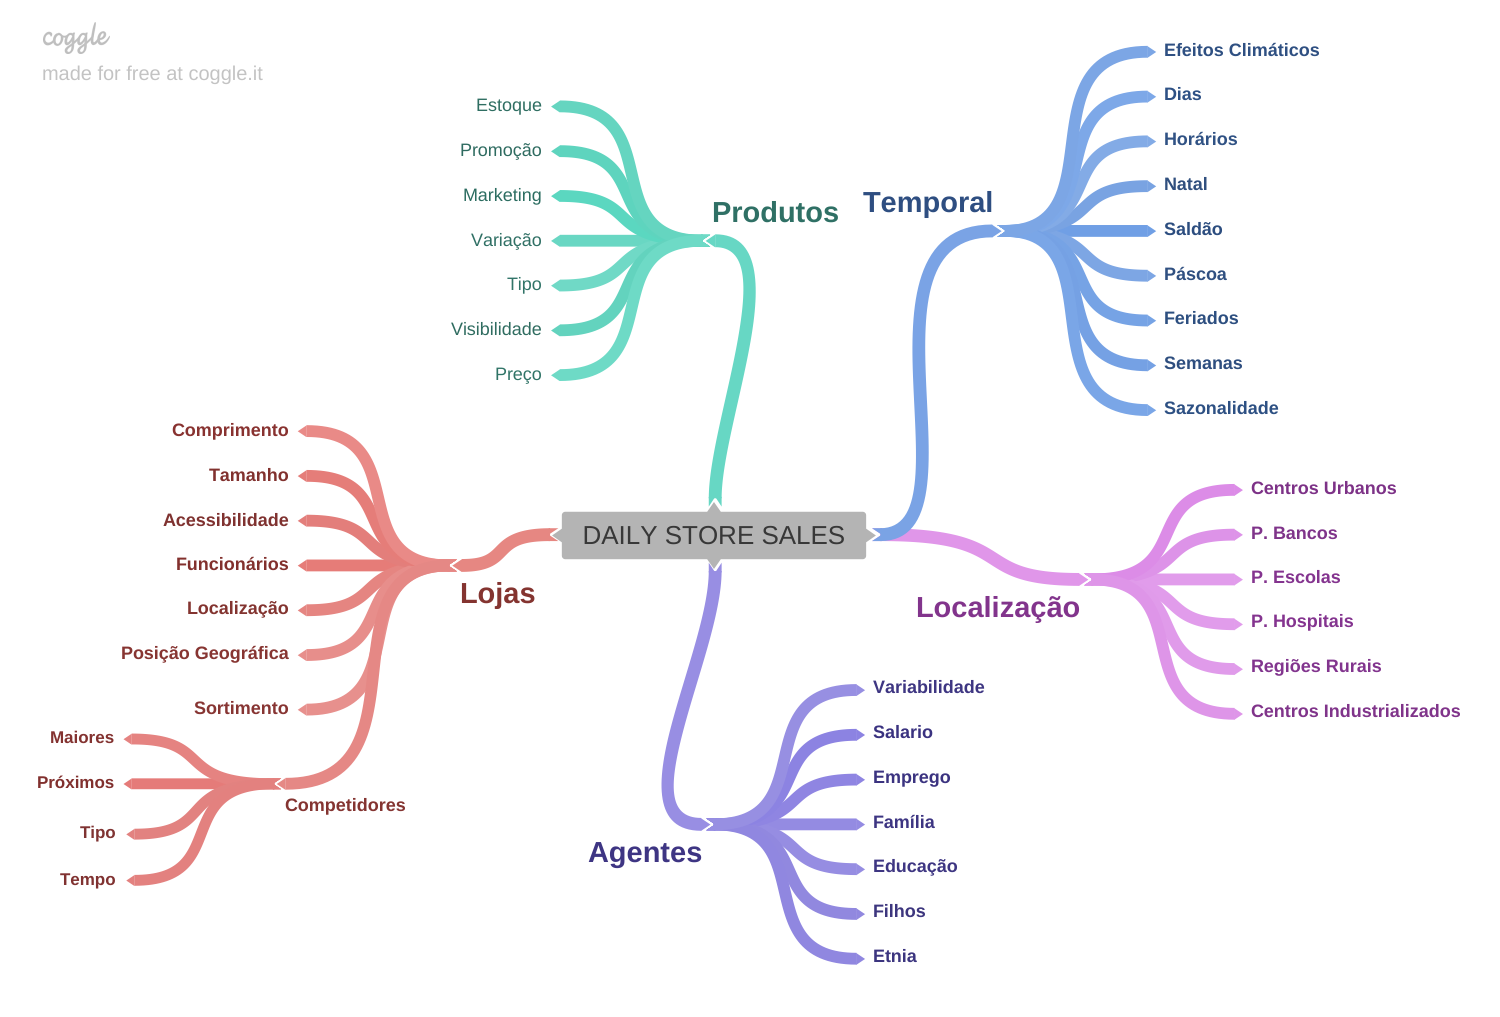

In [90]:
Image( '../img/mind_map.png' )

## 2.1 Hypotesis List


**1.** Lojas com maior sortimento, deveriam vender mais.

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas  com promoçoes ativas a mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com promoçoes consecutivas deveriam vender mais.

**7.** Lojas abertas nos feriados natalinos deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mes.

**11.** Lojas deveriam vender menos nos finais de semana.

**12** Lojas deveriam vender menos nos feriados escolares.

**13.** Lojas deveriam vender manso no segundo semestre do ano.

## 2.2 Feature Enginnering

In [93]:
df2 = df1.copy()

In [104]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# Year Week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition Since
df2['competition_since'] = df2.apply( lambda x: dt.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype('int64')

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype('str') + '-' + df2['promo2_since_week'].astype('str')
df2['promo_since'] = df2['promo_since'].apply( lambda x: dt.datetime.strptime( x + '-1', '%Y-%W-%w' ) - dt.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since']) / 7 ).apply( lambda x: x.days ).astype('int64')

# 3.0 Data Filtering

In [116]:
df3 = df2.copy()

In [117]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

In [118]:
drop_columns = ['open', 'customers', 'month_map', 'promo_interval']
df3 = df3.drop( drop_columns, axis=1 )

# 4.0 EDA!